# Saving and Reloading

In this example, we show how to save and reload results with `alabi`.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import alabi
from alabi.core import SurrogateModel
import alabi.utility as ut

In [7]:
def test1d_fn(theta):
    theta = np.asarray(theta)
    return -np.sin(3*theta) - theta**2 + 0.7*theta

# domain of the function
bounds = [(-2,3)]

If `cache` is set to `True` when initializing the surrogate model (the default behavior), `alabi` will automatically save your results at intermediate points:
- after initial training
- after each hyperparameter optimization
- after running MCMC

In [9]:
sm = SurrogateModel(lnlike_fn=test1d_fn, 
                    bounds=bounds, 
                    savedir=f"results/test1d",
                    theta_scaler=alabi.no_scaler,   # in this example, we won't scale inputs for training
                    y_scaler=alabi.no_scaler,
                    cache=True)                 # enable caching of results

sm.init_samples(ntrain=10, ntest=100, sampler="sobol")
sm.init_gp(kernel="ExpSquaredKernel", fit_amp=True, fit_mean=True, white_noise=-12, gp_scale_rng=[-1,1])
sm.active_train(niter=20, algorithm="bape", gp_opt_freq=10, obj_opt_method="nelder-mead")

Computed 10 function evaluations: 4.0s 

Computed 100 function evaluations: 4.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1
Optimized 4 hyperparameters: (0.027s)
Running 20 active learning iterations using bape...


 50%|█████     | 10/20 [00:00<00:00, 11.80it/s]

Optimized 4 hyperparameters: (0.012s)


100%|██████████| 20/20 [00:01<00:00, 11.60it/s]

Optimized 4 hyperparameters: (0.023s)
Caching model to results/test1d/surrogate_model...


At this point you should find several files saved in your specified save directory (`savedir`)

```
results/test1d/
    initial_training_sample.npz  
    surrogate_model.txt
    surrogate_model.pkl
```

- `initial_training_sample.npz` contains the initial training samples saved to a numpy file (which is useful if you run the initial samples in parallel, but switch to sequential sampling when running the active learning chain)

- `surrogate_model.txt` contains a summary of `alabi`'s configuration in a text file

- `surrogate_model.pkl` contains the saved `SurrogateModel` object which can be reloaded and rerun

### Results file after GP training

**surrogate_model.txt**

```
==================================================================
GP summary 
==================================================================

Configuration: 
-------------- 
Kernel: ExpSquaredKernel 
Function bounds: [[-2  3]] 
fit mean: True 
fit amplitude: True 
fit white_noise: True 
GP white noise: -12 
Hyperparameter bounds: [[ -3.63198075   1.15217628]
 [-15.          -9.        ]
 [  0.1         10.        ]
 [ -1.           1.        ]] 
Active learning algorithm : bape 

Number of total training samples: 30 
Number of initial training samples: 10 
Number of active training samples: 20 
Number of test samples: 100 

Results: 
-------- 
GP final hyperparameters: 
   [mean:value] 	0.22212174710423627 
   [white_noise:value] 	-13.414108468805813 
   [kernel:k1:log_constant] 	1.539832622117638 
   [kernel:k2:metric:log_M_0_0] 	-0.779896563686618 

Active learning train runtime (s): 1.0 

Final test error (MSE): 4.4642838595549054e-06 
```

### Reload the surrogate model function from pickle file

Load using the save directory you saved the results to:

In [16]:
sm = alabi.load_model_cache("results/test1d")  

In [17]:
sm.run_dynesty(like_fn=sm.surrogate_log_likelihood)

Initializing dynesty with self.surrogate_log_likelihood surrogate model as likelihood.
Initialized dynesty DynamicNestedSampler.
Running dynesty with 50 live points on 1 cores...


10267it [00:25, 405.71it/s, batch: 75 | bound: 0 | nc: 1 | ncall: 36822 | eff(%): 27.876 | loglstar: -5.331 <  0.500 <  0.216 | logz: -0.774 +/-  0.027 | stop:  0.991]     

Caching model to results/test1d/surrogate_model...


After running an MCMC sampler (with `emcee` or `dynesty`), `alabi` will update the `surrogate_model.txt` file 

```
results/test1d/
    initial_training_sample.npz  
    surrogate_model.txt
    surrogate_model.pkl
    dynesty_samples_final_surrogate_iter_20.npz
```

- `dynesty_samples_final_surrogate_iter_20.npz` contains the final posterior samples computed from dynesty after n iterations

**surrogate_model.txt** 

```
==================================================================
GP summary 
==================================================================

Configuration: 
-------------- 
Kernel: ExpSquaredKernel 
Function bounds: [[-2  3]] 
fit mean: True 
fit amplitude: True 
fit white_noise: True 
GP white noise: -12 
Hyperparameter bounds: [[ -3.63198075   1.15217628]
 [-15.          -9.        ]
 [  0.1         10.        ]
 [ -1.           1.        ]] 
Active learning algorithm : bape 

Number of total training samples: 30 
Number of initial training samples: 10 
Number of active training samples: 20 
Number of test samples: 100 

Results: 
-------- 
GP final hyperparameters: 
   [mean:value] 	-0.1412005223011758 
   [white_noise:value] 	-12.0 
   [kernel:k1:log_constant] 	1.7443253209346983 
   [kernel:k2:metric:log_M_0_0] 	-0.08685227966604564 

Active learning train runtime (s): 1.0 

Final test error (MSE): 4.4642838595549054e-06 

==================================================================
dynesty summary 
==================================================================

Configuration: 
-------------- 
Results: 
-------- 
Total weighted samples: 10362 

Dynesty runtime (s): 24.0 

Summary statistics: 
theta_{i} = 0.2781219235609284 +/- 0.8305605738406258 
```

### Saving Plots

Any plots generated from `sm.plot()` will also be saved to the same savedir

```
results/test1d/
    initial_training_sample.npz  
    surrogate_model.txt
    surrogate_model.pkl
    dynesty_samples_final_surrogate_iter_20.npz
    gp_mse_vs_iteration.png
```

Plotting the gp mean squared error with 100 test samples...
Saving to results/test1d/gp_mse_vs_iteration.png


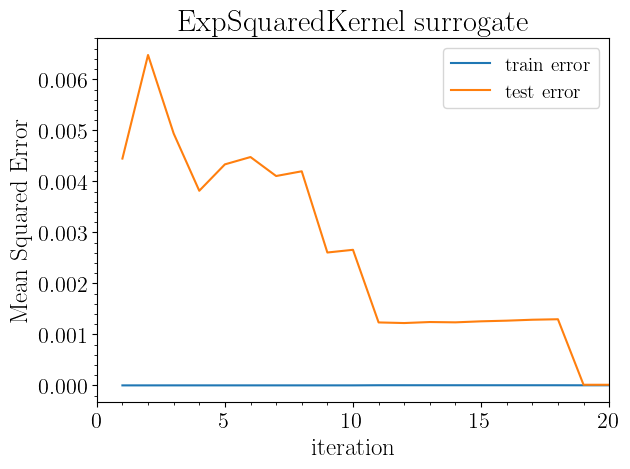

In [18]:
sm.plot(plots=["test_mse"])